<a href="https://colab.research.google.com/github/andreabazerla/real-estate/blob/main/Real_Estate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Price Prediction in Milan (Italy) through Deep Learning via immobiliare.it

<img src="https://media.giphy.com/media/gTURHJs4e2Ies/source.gif" />

## Web Scraping: immobiliare.it

In [1]:
import os
import logging
import math
import numpy as np
from google.colab import files
import requests
from enum import Enum 
from random import uniform
import time
import datetime
import json
from bs4 import BeautifulSoup
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sb

In [2]:
PRODUCTION = True
GET_ADS_LINKS = False
GET_ADS_LIST = True

In [ ]:
def get_timestamp():
  return str(int(time.time()))

In [19]:
pd.option_context('display.max_rows', None, 'display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
class Contract(Enum):
  VENDITA = 'vendita'
  AFFITTO = 'affitto'
 
class Area(Enum):
  MILANO = 'milano'

In [ ]:
slash = '/'
https = 'https://'
website = 'www.immobiliare.it'
contract = Contract.VENDITA.value + '-case'
area = Area.MILANO.value
sort = '?criterio=rilevanza'
 
url = https + website + slash + contract + slash + area + slash + sort
 
print('url = ' + url)

In [ ]:
sleep_min = 2
sleep_max = 3

def sleep_default():
  time.sleep(uniform(sleep_min, sleep_max))

### Ads Link Scraping

In [ ]:
def get_last_page(url):
  sleep_default()
  
  try:
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
  
    ul_pagination = soup.find("ul", class_ = "pagination pagination__number")
    li_list = ul_pagination.find_all("li")
    last_page = int(li_list[-1].get_text().strip())
  
    return last_page
  
  except requests.exceptions.RequestException as e:
    raise SystemExit(e)

#last_page = get_last_page(url)
#print('Last page = ' + str(last_page))

In [ ]:
def get_ads_link_list(url, first_page, last_page):
  ads_link_list = []
  
  pag = first_page
  
  while (pag <= last_page):
    if (pag > 1):
      url = url + '&pag=' + str(pag)
    
    try:
      response = requests.get(url)

      soup = BeautifulSoup(response.content, 'html.parser')
    
      ads_list = soup.find('ul', class_ = 'annunci-list')
      ad_item_list = ads_list.find_all('div', class_ = 'listing-item_body--content')
      for ad_item in ad_item_list:
        a_list = ad_item.find_all("a")
        for a in a_list:
          href = a["href"]
          ads_link_list.append(href)
    
    except Exception as e:
      logging.exception(e)
      print(str(pag))
      pass
    
    pag += 1
 
    sleep_default()
  
  return ads_link_list

In [ ]:
if PRODUCTION:
  if GET_ADS_LINKS:
    first_page = 1
    #last_page = 631
    last_page = get_last_page(url)
  
    ads_link_list = get_ads_link_list(url, first_page, last_page)
    ads_link_list = list(dict.fromkeys(ads_link_list))
    
    print('Total number of ads = ' + str(len(ads_link_list)))

In [ ]:
df_links = pd.DataFrame({'Links' : list(ads_link_list)})

csv_links = 'Links_' + str(int(time.time())) + '_' + str(first_page) + '_' + str(last_page) + '.csv'
df_links.to_csv(csv_links, index=False)

In [ ]:
display(df_links)

In [ ]:
files.download(csv_links)

### Ads Scraping

In [ ]:
def get_ad_title(soup):
  titleBlock__title = soup.find('span', class_ = 'im-titleBlock__title')
  if titleBlock__title is not None:
    return titleBlock__title.get_text()
  else:
    return ''

In [ ]:
def get_ad_price(soup):
  mainFeatures__price = soup.find_all('li', class_ = 'im-mainFeatures__price')
  if mainFeatures__price:
    return mainFeatures__price[0].get_text().replace('\n', '').strip()
  else:
    return ''

In [ ]:
def get_ad_main_feature(soup):
  main_features = {}
  
  mainFeatures = soup.find('div', class_ = 'im-mainFeatures')
  
  li_list = mainFeatures.find_all('li')
  for li in li_list[1:]:
    value = li.find('span', class_="im-mainFeatures__value").get_text().replace('\n', '').strip()
    label = li.find('span', class_="im-mainFeatures__label").get_text().replace('\n', '').strip()
    
    if (label == 'bagno' or label == 'bagni'):
      label = 'bagni'
    
    if (label == 'locale' or label == 'locali'):
      label = 'locali'
    
    main_features[label] = value
  
  return main_features

In [ ]:
def get_ad_description(soup):
  description__text = soup.find('div', class_ = 'im-description__text')
  if description__text is not None:
    return description__text.get_text()
  else:
    return ''

In [ ]:
def get_ad_locations(soup):
  location_list = []
  
  titleBlock__link = soup.find('a', class_ = 'im-titleBlock__link')
  if titleBlock__link is None:
    titleBlock__link = soup.find('h1', class_ = 'im-titleBlock__content')

  location = titleBlock__link.find_all('span', class_ = 'im-location')
  
  try:
    area = location[0].get_text().strip()
  except IndexError:
    area = ''
  
  try:
    district = location[1].get_text().strip()
  except IndexError:
    district = ''

  try:
    address = location[2].get_text().strip()
  except IndexError:
    address = ''

  return [area, district, address]

In [ ]:
def get_ad_feature_list(soup):
  features = {}
  
  features__list = soup.find_all("dl", class_ = "im-features__list")
  
  for feature_block in features__list:
    feature__title_list = feature_block.find_all('dt', class_ = 'im-features__title')
  
    for feature__title in feature__title_list:
      feature__value = feature__title.findNext('dd')
  
      if ('im-features__tagContainer' in feature__value.get('class')):
        features__tag_array = []

        features__tag_list = soup.find_all('span', class_ = 'im-features__tag')
        for feature__tag in features__tag_list:
          features__tag_array.append(feature__tag.get_text().strip())
  
        features__tag_list_string = ','.join(features__tag_array)
        feature__value_2 = features__tag_list_string
  
      else:
        feature__value_2 = feature__value.get_text().strip()
  
      feature__title_2 = feature__title.get_text().strip()
      features['f_' + feature__title_2] = feature__value_2
  
  return features

In [ ]:
def get_ad(url):
  if 'p-' in url:
    return get_ad_multi(url)
  else:
    return get_ad_single(url)

In [ ]:
def get_ad_single(url):
  ads_list = []
  ad_data = {}

  ad_data['url'] = url

  try:
    response = requests.get(url)
    if response:
      soup = BeautifulSoup(response.content, "html.parser")

      title = get_ad_title(soup);
      ad_data['titolo'] = title

      price = get_ad_price(soup);
      ad_data['prezzo'] = price

      main_features = get_ad_main_feature(soup)
      if main_features:
        ad_data.update(main_features)

      description = get_ad_description(soup);
      ad_data['descrizione'] = description

      area, district, address = get_ad_locations(soup)
      ad_data['area'] = area
      ad_data['quartiere'] = district
      ad_data['indirizzo'] = address

      feature_list = get_ad_feature_list(soup)
      if feature_list:
        ad_data.update(feature_list)

      ad_data['hashcode'] = hash(frozenset(ad_data.items()))

      ads_list.append(ad_data)
  
  except Exception as e:
    logging.exception(e)
    print(url)
    pass

  return ads_list

In [ ]:
def get_ad_multi(url):
  ads_list = []

  try:
    response = requests.get(url)
    if response:
      soup = BeautifulSoup(response.content, 'html.parser')

      title = get_ad_title(soup);

      area, district, address = get_ad_locations(soup)

      main_features = get_ad_main_feature(soup)

      description = get_ad_description(soup)

      feature_list = get_ad_feature_list(soup)

      properties__list = soup.find('ul', class_ = 'im-properties__list')
      properties__item_list = properties__list.find_all('li', class_ = 'im-properties__item')
      for properties__item in properties__item_list:
        ad_data = {}

        ad_data['url'] = url

        ad_data['titolo'] = title

        ad_data['area'] = area
        ad_data['quartiere'] = district
        ad_data['indirizzo'] = address
        
        price = get_ad_price(properties__item)
        ad_data['prezzo'] = price

        ad_data['descrizione'] = description

        sub_features = get_ad_main_feature(properties__item)
        if sub_features:
          ad_data.update(sub_features)

        title_2 = properties__item.find('p', class_ = 'nd-mediaObject__title')
        if title_2 is not None:
          ad_data['titolo_2'] = title_2.get_text().strip()

        description_2 = properties__item.find('div', class_ = 'im-properties__content')
        if description_2 is not None:
          ad_data['descrizione_2'] = description_2.get_text()

        if feature_list:
          ad_data.update(feature_list)

        ad_data['hashcode'] = hash(frozenset(ad_data.items()))

        ads_list.append(ad_data)

  except Exception as e:
    logging.exception(e)
    print(url)
    pass
  
  return ads_list

In [ ]:
df_links = pd.read_csv('Links_1616797839_1_630.csv')
ads_link_list = df_links['Links'].to_list()

In [ ]:
if PRODUCTION:
  if GET_ADS_LIST:
    df_ads = pd.DataFrame()

    first_ad = 1000
    last_ad = 1500
    #last_ad = len(ads_link_list)

    #if (first_ad > last_ad)
    
    ads_csv = 'Ads_' + get_timestamp() + '_' + str(first_ad) + '_' + str(last_ad - 1) + '.csv'

    ads_list = []
    for i in tqdm(range(first_ad, last_ad)):

      try:
        ad_data = get_ad(ads_link_list[i])
        for ad in ad_data:
          ads_list.append(ad)
      except Exception as e:
        logging.exception(e)
        print(i)
        pass
      
      sleep_default()
    
    df_ads = pd.DataFrame(ads_list)
    df_ads.fillna('', inplace=True)
    df_ads.to_csv(ads_csv, index=False)

In [ ]:
  display(df_ads)

In [ ]:
files.download(ads_csv)

In [ ]:
ads_folder = 'Ads'
file_list = os.listdir(ads_folder)
ads_files = [file for file in file_list if file.startswith('Ads')]
ads_files.sort()

df_files = [None] * len(ads_files)
for idx, file in enumerate(ads_files):
  df_files[idx] = pd.read_csv(os.path.join(ads_folder, file))

df_final = pd.concat(df_files).drop_duplicates().reset_index(drop=True)

ads_csv_final = 'Ads' + '_' + get_timestamp() + '.csv'
df_final.to_csv(ads_csv_final, index=False)

In [ ]:
files.download(ads_csv_final)

### Clean Ads CSV

In [21]:
df_ads = pd.read_csv('Ads_1617101603.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (63,67,68,69,70) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
df_ads_single = df_ads[~df_ads['url'].str.contains('p-')]
#len(df_ads_single.index)
# 5244 - 4873 = 371

In [ ]:
columns = list(df_ads_single.columns.values)
for column in columns:
  print(column)

In [ ]:
print(df_ads_single['url'].duplicated().any())
print(df_ads_single['hashcode'].duplicated().any())

In [23]:
index_names = df_ads_single[
  (df_ads_single['f_offerta minima'].notnull()) #14736
  | (df_ads_single['f_rialzo minimo'].notnull()) #14644
  | (df_ads_single['f_Spesa prenota debito'].notnull()) #14625
  | (df_ads_single['f_Contributo non dovuto'].notnull()) #14625
  | (df_ads_single['f_Tribunale'].notnull()) #14617
  | (df_ads_single['f_termine presentazione'].notnull()) #14617
  | (df_ads_single['f_lotto numero'].notnull()) #14615
  | (df_ads_single['f_Deposito cauzionale'].notnull()) #14615
  | (df_ads_single['f_luogo vendita'].notnull()) #14615
  | (df_ads_single['f_Luogo presentazione'].notnull()) #14615
  | (df_ads_single['f_categoria'].notnull()) #14605
  | (df_ads_single['f_Procedura'].notnull()) #14587
  | (df_ads_single['f_numero procedura'].notnull()) #14587
  | (df_ads_single['f_Delegato'].notnull()) #14587
  | (df_ads_single['f_Giudice'].notnull()) #14587
  | (df_ads_single['f_Custode'].notnull()) #14587
  | (df_ads_single['f_Dati catastali'].notnull()) #14550
  | (df_ads_single['f_Rialzo minimo in caso di gara'].notnull()) #14550
  | (df_ads_single['f_Motivo esenzione'].notnull()) #14550
  | (df_ads_single['f_note'].notnull()) #14550
  | (df_ads_single['f_Rito'].notnull()) #14550
  | (df_ads_single['f_Curatore'].notnull()) #14550
  | (df_ads_single['f_Altri dati catastali'].notnull()) #14550
  | (df_ads_single['f_Deposito conto spese'].notnull()) #14550
  | (df_ads_single['f_Cauzione e spese'].notnull()) #14550
  | (df_ads_single['f_Referente'].notnull()) #14550
  | (df_ads_single['f_valore perizia'].notnull()) #14550
  | (df_ads_single['f_Delegato alla vendita'].notnull()) #14550
].index

df_ads_auction = df_ads_single.drop(index_names)

In [149]:
columns_useless = [
  'area',
  'descrizione',
  'titolo_2',
  'descrizione_2',
  'f_superficie',
  'f_prezzo',
  'f_riferimento e Data annuncio',
  'f_immobile garantito',
  'f_contratto',
  'f_unità',
  'f_Data di inizio lavori e di consegna prevista',
  'f_Indice prest. energetica rinnovabile',
  'f_Prestazione energetica del fabbricato',
  'f_disponibilità',
  'f_certificazione energetica',
  'f_numero immobili',
  'f_aggiornato il',
  'hashcode',
  'data vendita',
  'f_Tipo vendita',
  'f_data vendita',
  'f_offerta minima',
  'f_rialzo minimo',
  'f_Spesa prenota debito',
  'f_Contributo non dovuto',
  'f_Tribunale',
  'f_termine presentazione',
  'f_lotto numero',
  'f_Deposito cauzionale',
  'f_luogo vendita',
  'f_Luogo presentazione',
  'f_categoria',
  'f_Procedura',
  'f_numero procedura',
  'f_Delegato',
  'f_Giudice',
  'f_Custode',
  'f_Dati catastali',
  'f_Rialzo minimo in caso di gara',
  'f_Motivo esenzione',
  'f_note',
  'f_Rito',
  'f_Curatore',
  'f_Altri dati catastali',
  'f_Deposito conto spese',
  'f_Cauzione e spese',
  'f_Referente',
  'f_valore perizia',
  'f_Delegato alla vendita'
]

df_ads_columns = df_ads_auction.drop(columns_useless, axis=1)

In [ ]:
columns = list(df_ads_columns.columns.values)
for column in columns:
  print(column)

In [139]:
#df_ads_columns.loc[df_ads_columns['prezzo'] == 'Prezzo su richiesta', 'prezzo'] = ''
#df_ads_columns.loc[df_ads_columns['f_prezzo'] == 'Prezzo su richiesta', 'f_prezzo'] = ''

df_ads_columns['prezzo'] = df_ads_columns['prezzo'].replace('[\€\,\.]', '', regex=True)
#df_ads_columns['f_prezzo'] = df_ads_columns['f_prezzo'].replace('[\€\,\.]', '', regex=True)
df_ads_columns['prezzo'] = df_ads_columns['prezzo'].str.extract('(\d+)')
#df_ads_columns['f_prezzo'] = df_ads_columns['f_prezzo'].str.extract('(\d+)')

df_ads_columns['superficie'] = df_ads_columns['superficie'].str.extract('(\d+)')
#df_ads_columns['f_superficie'] = df_ads_columns['f_superficie'].str.extract('(\d+)')

#df_ads_columns['price_equal'] = np.where(df_ads_columns['prezzo'] == df_ads_columns['f_prezzo'], 0, 1)
#df_ads_columns['price_equal'].value_counts()
#df_ads_price_nan = df_ads_columns.loc[(df_ads_columns['prezzo'] != df_ads_columns['f_prezzo']) & (df_ads_columns['prezzo'].isna()) & (~df_ads_columns['f_prezzo'].isna())]
#len(df_ads_price_nan.index)
#df_ads_price_nan['prezzo'].value_counts()
#del df_ads_columns['price_equal']

df_ads_price_nan = df_ads_columns.loc[(df_ads_columns['prezzo'].isna())]
len(df_ads_price_nan.index)

df_ads_columns = df_ads_columns.loc[(~df_ads_columns['prezzo'].isna())]
#len(df_ads_price_not_nan.index)

#df_ads_surface = df_ads_price_not_nan.loc[(df_ads_price_not_nan['superficie'] != df_ads_price_not_nan['f_superficie'])]
df_ads_surface_not_null = df_ads_columns.loc[(~df_ads_columns['superficie'].isna())]

df_ads_surface_not_null['f_totale piani edificio'] = df_ads_surface_not_null['f_totale piani edificio'].str.extract('(\d+)')

df_ads_surface_not_null['f_spese condominio'] = df_ads_surface_not_null['f_spese condominio'].str.extract('(\d+)')

df_ads_surface_not_null['prezzo'] = df_ads_surface_not_null['prezzo'].astype(int)
df_ads_surface_not_null['superficie'] = df_ads_surface_not_null['superficie'].astype(str).astype(int)
df_ads_surface_not_null['f_anno di costruzione'] = df_ads_surface_not_null['f_anno di costruzione'].astype('Int64')

len(df_ads_nan.index)


25

In [150]:
df_ads_columns['prezzo'] = df_ads_columns['prezzo'].replace('[\€\,\.]', '', regex=True)
df_ads_columns['prezzo'] = df_ads_columns['prezzo'].str.extract('(\d+)')
df_ads_columns = df_ads_columns.dropna(subset=['prezzo'])
df_ads_columns['prezzo'] = df_ads_columns['prezzo'].astype(int)
#df_ads_price_nan = df_ads_columns.loc[(df_ads_columns['prezzo'].isna())]
#print(df_ads_columns['prezzo'].unique())

df_ads_columns['superficie'] = df_ads_columns['superficie'].str.extract('(\d+)')
df_ads_columns = df_ads_columns.dropna(subset=['superficie'])
df_ads_columns['superficie'] = df_ads_columns['superficie'].astype(int)

df_ads_columns['bagni'] = df_ads_columns['bagni'].replace('3+', '4')
df_ads_columns['bagni'] = df_ads_columns['bagni'].str.extract('(\d+)')
df_ads_columns['bagni'] = df_ads_columns['bagni'].fillna(0)
df_ads_columns['bagni'] = df_ads_columns['bagni'].astype(int)

df_ads_columns['locali'] = df_ads_columns['locali'].replace('5+', '6')
df_ads_columns['locali'] = df_ads_columns['locali'].str.extract('(\d+)')
df_ads_columns = df_ads_columns.dropna(subset=['locali'])
df_ads_columns['locali'] = df_ads_columns['locali'].astype(int)

df_ads_nan = df_ads_columns.loc[(df_ads_columns['f_spese condominio'].isna())]
df_ads_columns['f_spese condominio'] = df_ads_columns['f_spese condominio'].str.extract('(\d+)')
df_ads_columns['f_spese condominio'] = df_ads_columns['f_spese condominio'].fillna(0)
df_ads_columns['f_spese condominio'] = df_ads_columns['f_spese condominio'].astype(int)

df_ads_columns['f_totale piani edificio'] = df_ads_columns['f_totale piani edificio'].str.extract('(\d+)')
df_ads_columns = df_ads_columns.dropna(subset=['f_totale piani edificio'])
df_ads_columns['f_totale piani edificio'] = df_ads_columns['f_totale piani edificio'].astype(int)

df_ads_columns = df_ads_columns.dropna(subset=['f_anno di costruzione'])
df_ads_columns['f_anno di costruzione'] = df_ads_columns['f_anno di costruzione'].astype(int)

11262

In [152]:
display(df_ads_columns)

,url,titolo,quartiere,indirizzo,prezzo,superficie,bagni,piano,f_Tipo proprietà,f_stato,f_Efficienza energetica,locali,f_tipologia,f_locali,f_piano,f_totale piani edificio,f_Posti Auto,f_altre caratteristiche,f_spese condominio,f_anno di costruzione,f_riscaldamento,f_Climatizzazione
2,https://www.immobiliare.it/annunci/68088357/,"Attico via delle Forze Armate 107, Milano",Primaticcio,Via delle Forze Armate,680000,168,2,A,"Intera proprietà, classe immobile signorile",Nuovo / In costruzione,"A 74,25 kWh/m² anno",3,Attico,"3 (2 camere da letto, 1 altro), 2 bagni, cucina abitabile","Ultimo, con ascensore, con accesso disabili",6,1 in garage/box,"Cancello elettrico,Fibra ottica,VideoCitofono,Impianto di allarme,Porta blindata,Balcone,Terrazza,Impianto tv con parabola satellitare,Giardino comune,Infissi esterni in triplo vetro / metallo,Esposizione doppia",300,2014,"Centralizzato, a pavimento, alimentato a metano","Autonomo, freddo/caldo"
3,https://www.immobiliare.it/annunci/84184532/,"Bilocale via Giambellino 100, Milano",Giambellino,via Giambellino 100,225000,52,1,2,"Intera proprietà, classe immobile media",Buono / Abitabile,"D 89,80 kWh/m² anno",2,Appartamento,"2 (1 camera da letto, 1 altro), 1 bagno, cucina a vista","2° piano, con ascensore",4,1 in garage/box,"Fibra ottica,Porta blindata,Esposizione esterna,Terrazza,Impianto tv centralizzato",133,2009,"Autonomo, a radiatori, alimentato a metano",NaN
7,https://www.immobiliare.it/annunci/85213731/,"Trilocale viale Nazario Sauro 5, Milano",Isola,Viale Nazario Sauro,320000,80,1,R,"Intera proprietà, classe immobile signorile",Ottimo / Ristrutturato,"G 175,00 kWh/m² anno",3,Appartamento,"3 (2 camere da letto, 1 altro), 1 bagno, cucina abitabile",Piano rialzato,4,NaN,"Cancello elettrico,Fibra ottica,Porta blindata,Esposizione interna,Armadio a muro,Portiere intera giornata,Impianto tv centralizzato,Parzialmente Arredato,Giardino comune,Infissi esterni in doppio vetro / PVC",71,1900,"Autonomo, a radiatori, alimentato a metano",NaN
15,https://www.immobiliare.it/annunci/84584118/,"Attico via Panfilo Castaldi 35, Milano",Porta Venezia,Via Panfilo Castaldi,1150000,160,2,5,"Intera proprietà, classe immobile signorile",Buono / Abitabile,G ≥ 175 kWh/m² anno,5,Attico,"5 (3 camere da letto, 2 altri), 2 bagni, cucina abitabile","5°, con ascensore, con accesso disabili",6,"1 in garage/box, 1 all'esterno","Mansarda,Fibra ottica,VideoCitofono,Porta blindata,Armadio a muro,Balcone,Terrazza,Impianto tv centralizzato,Cantina,Giardino comune,Infissi esterni in doppio vetro / PVC,Esposizione doppia",300,1900,"Autonomo, a radiatori, alimentato a gas","Autonomo, freddo"
16,https://www.immobiliare.it/annunci/85398530/,"Appartamento viale Gran Sasso, Milano",Città Studi,viale Gran Sasso,980000,210,2,2,"Intera proprietà, classe immobile signorile",Da ristrutturare,"E 169,59 kWh/m² anno",6,Appartamento,"5+ (5 camere da letto, 3 altri), 2 bagni, cucina abitabile","2°, con ascensore",7,NaN,"Cancello elettrico,Fibra ottica,VideoCitofono,Porta blindata,Balcone,Portiere intera giornata,Impianto tv centralizzato,Cantina,Infissi esterni in doppio vetro / legno,Esposizione doppia",500,1950,"Centralizzato, a radiatori, alimentato a metano","Autonomo, freddo"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15695,https://www.immobiliare.it/annunci/86376070/,"Bilocale ottimo stato, primo piano, Milano",Quinto Romano,NaN,130000,70,1,1,"Intera proprietà, classe immobile economica",Ottimo / Ristrutturato,"F 273,90 kWh/m² anno",2,Appartamento,"2 (1 camera da letto, 1 altro), 1 bagno, cucina a vista",1°,1,NaN,"Caminetto,Mansarda,Fibra ottica,Porta blindata,Armadio a muro,Balcone,Impianto tv centralizzato,Arredato,Infissi esterni in doppio vetro / legno,Esposizione doppia",100,1930,"Autonomo, a radiatori, alimentato a metano","Autonomo, freddo/caldo"
15697,https://www.immobiliare.it/annunci/73648362/,"Quadrilocale via Garian 18, Milano",Washington,Via Garian,750000,160,3,2,Classe immob

In [ ]:
csv_ads_clean = 'Ads_' + get_timestamp() + '_clean' +  '.csv'
df_ads_columns.to_csv(csv_ads_clean, index=False)
files.download(csv_ads_clean)

In [ ]:
df_ads_clean = pd.read_csv('Ads_1617124488_clean.csv')

## Data Analysis

### Pearson

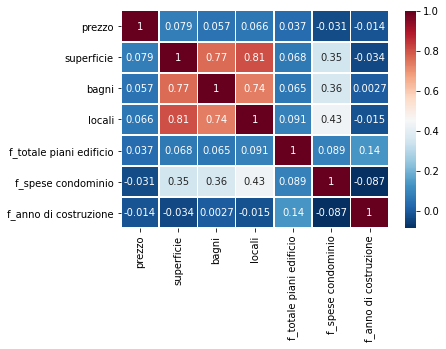

In [153]:
pearson = df_ads_columns.corr(method='pearson')

pearson

sb.heatmap(pearson, 
            xticklabels=pearson.columns,
            yticklabels=pearson.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

### Get Geographic Coordinates from Ads Addresses

In [ ]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 

# Install rtree - Geopandas requirment
!apt install python3-rtree

# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git

# Install descartes - Geopandas requirment
!pip install descartes

# Install Folium for Geographic data visualization
!pip install folium

# Install plotlyExpress
!pip install plotly_express

In [ ]:
import numpy as np
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px
import folium
from folium.plugins import FastMarkerCluster

In [ ]:
locator = Nominatim(user_agent='myGeocoder')
location = locator.geocode('Via Ferdinando Prampolini, 9, Ferrara')

print(location.address)
print("{}, {}".format(location.latitude, location.longitude))

## Artificial Neural Network